# **MOVIE_DATA_ANALYSIS🎥🎬🎞️🍿**

## **과제 3️⃣**
### 배우/감독 네트워크 분석 및 성공 패턴 발견

#### 주요 배우와 감독들의 협업 관계를 네트워크로 시각화하고, 성공적인 콜라보레이션 패턴을 발견하여 캐스팅 전략에 대한 인사이트를 도출하세요.

#### **TOP 40 감독-배우 콤보 네트워크 분석**

전체 데이터 수: 927개
필터링 후 데이터 수: 927개

📊 네트워크 분석 설정:
상위 배우 수: 10명
최소 협업 횟수: 2회
정렬 기준: avg_revenue
상위 엣지 수: 50개

🤝 협업 데이터 생성:
총 협업 관계: 8,838개
유효한 협업 관계: 341개

📈 상위 50개 협업 관계:


,감독,배우,협업횟수,평균수익
1,김용화,김향기,2,1091.0억원
2,김용화,도경수,2,1091.0억원
3,김용화,이준혁,2,1091.0억원
4,김용화,주지훈,2,1091.0억원
5,최동훈,오달수,2,959.5억원
6,최동훈,이정재,2,959.5억원
7,최동훈,전지현,2,959.5억원
8,김한민,류승룡,2,957.1억원
9,김용화,김동욱,4,759.8억원
10,이병헌,양현민,2,746.3억원



🕸️ 네트워크 그래프:
노드 수: 63개
엣지 수: 50개

🎨 네트워크 시각화 완료!


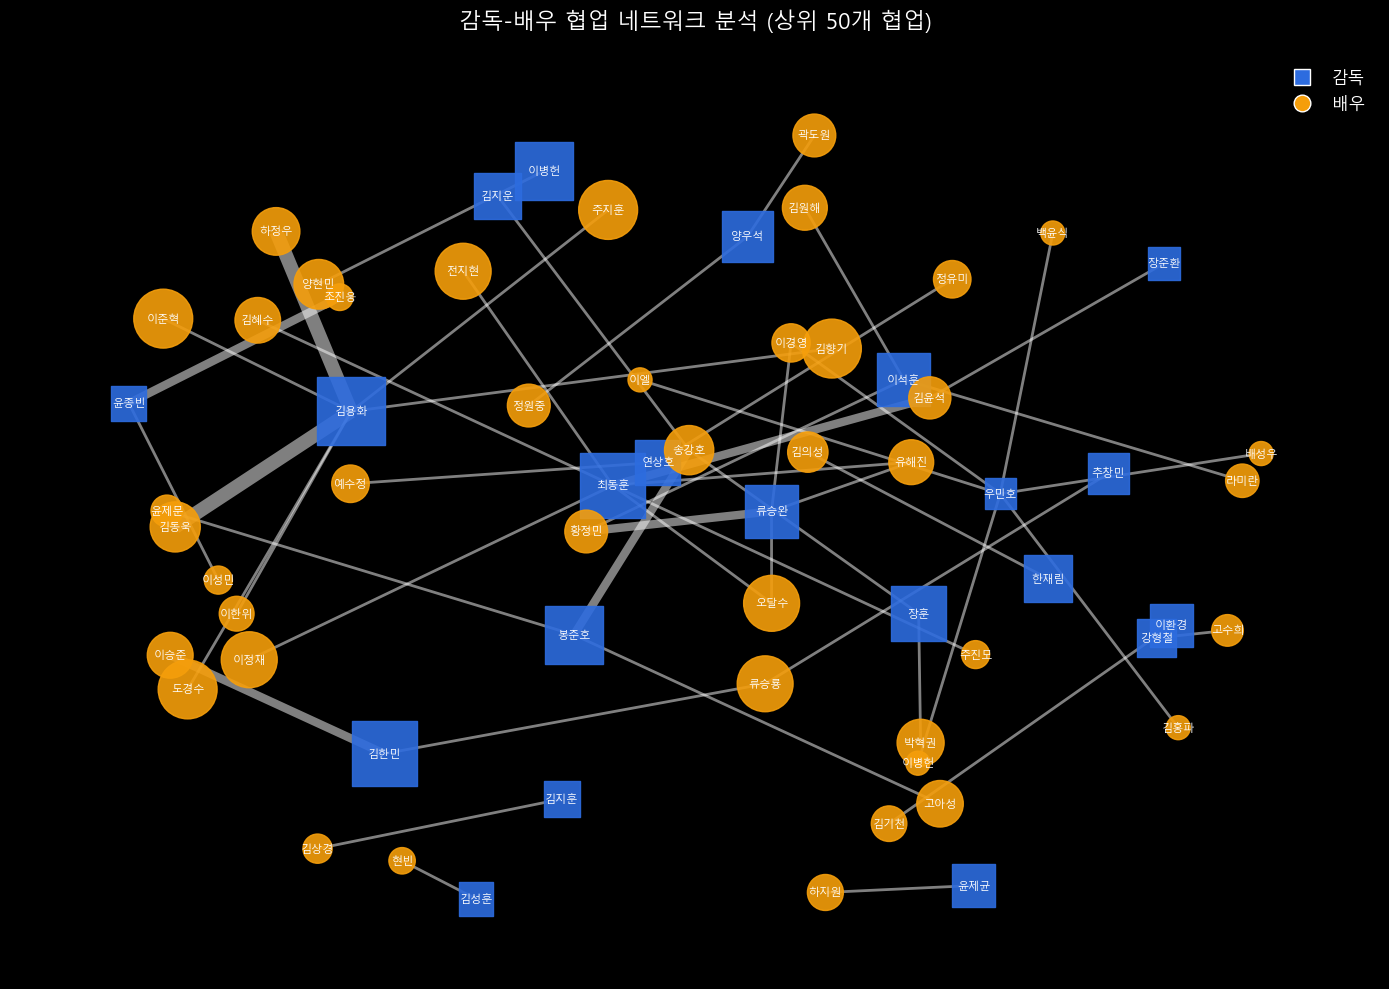

In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice
from IPython.display import display
import warnings

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore', category=UserWarning)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 파일 경로
file_path = './data/processed/kobis_weekly_final.csv'

# 데이터 로드
df = pd.read_csv(file_path)

print(f"전체 데이터 수: {len(df):,}개")

# 숫자형 컬럼 변환
numeric_columns = ['release_year', 'budget', 'revenue', 'vote_average', 'runtime']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 기간 필터링 (2005-2025)
if 'release_year' in df.columns:
    df = df[df['release_year'].between(2005, 2025)]

print(f"필터링 후 데이터 수: {len(df):,}개")

# ROI 및 순이익 계산
df['roi'] = np.where((df['budget'] > 0) & (df['revenue'] > 0),
                     df['revenue'] / df['budget'], np.nan)
df['net_profit'] = df['revenue'] - df['budget']

# 파이프 구분자 파싱 함수
def split_pipe(s):
    return [x.strip() for x in str(s).split('|') if x.strip()]

# 분석 파라미터 설정
TOP_N_CAST = 10  # 상위 배우 N명
MIN_COLLABS = 2  # 최소 협업 횟수
METRIC_EDGE_ORDER = 'avg_revenue'  # 정렬 기준
TOP_K_EDGES = 50  # 상위 K개 엣지

print(f"\n📊 네트워크 분석 설정:")
print(f"상위 배우 수: {TOP_N_CAST}명")
print(f"최소 협업 횟수: {MIN_COLLABS}회")
print(f"정렬 기준: {METRIC_EDGE_ORDER}")
print(f"상위 엣지 수: {TOP_K_EDGES}개")

# 감독-배우 협업 데이터 생성
collaboration_data = []

for _, row in df.iterrows():
    director = str(row.get('director_name_ko', '')).strip()
    if not director:
        continue
    
    cast_list = split_pipe(row.get('cast_names_ko', ''))
    
    for actor in cast_list[:TOP_N_CAST]:
        collaboration_data.append({
            'director_label': director,
            'actor_label': actor,
            'movie_id': row.get('movie_id'),
            'release_year': row.get('release_year'),
            'revenue': row.get('revenue'),
            'budget': row.get('budget'),
            'roi': row.get('roi'),
            'net_profit': row.get('net_profit')
        })

print(f"\n🤝 협업 데이터 생성:")
print(f"총 협업 관계: {len(collaboration_data):,}개")

# 협업 통계 집계
collaboration_df = pd.DataFrame(collaboration_data)
edges_df = (collaboration_df
            .groupby(['director_label', 'actor_label'], as_index=False)
            .agg(
                n_collabs=('movie_id', 'nunique'),
                avg_revenue=('revenue', 'mean'),
                avg_roi=('roi', 'mean'),
                avg_net_profit=('net_profit', 'mean'),
                first_year=('release_year', 'min'),
                last_year=('release_year', 'max')
            )
            .query('n_collabs >= @MIN_COLLABS')
            .sort_values([METRIC_EDGE_ORDER, 'n_collabs'], ascending=[False, False])
           )

print(f"유효한 협업 관계: {len(edges_df)}개")

# 상위 협업 관계 선택
top_edges = edges_df.head(TOP_K_EDGES).copy()

print(f"\n📈 상위 {TOP_K_EDGES}개 협업 관계:")
display_edges = top_edges[['director_label', 'actor_label', 'n_collabs', 'avg_revenue']].copy()
display_edges['avg_revenue'] = display_edges['avg_revenue'].apply(lambda x: f"{x/1e8:.1f}억원")
display_edges.columns = ['감독', '배우', '협업횟수', '평균수익']
display_edges.index = range(1, len(display_edges) + 1)
display(display_edges.head(10))

# 네트워크 그래프 생성
G = nx.Graph()

for _, row in top_edges.iterrows():
    director_node = ('director', row['director_label'])
    actor_node = ('actor', row['actor_label'])
    
    G.add_node(director_node, role='director', label=row['director_label'])
    G.add_node(actor_node, role='actor', label=row['actor_label'])
    
    G.add_edge(director_node, actor_node,
               weight=int(row['n_collabs']),
               avg_revenue=float(row['avg_revenue']) if pd.notna(row['avg_revenue']) else 0.0,
               avg_net_profit=float(row['avg_net_profit']) if pd.notna(row['avg_net_profit']) else 0.0,
               avg_roi=float(row['avg_roi']) if pd.notna(row['avg_roi']) else 0.0)

print(f"\n🕸️ 네트워크 그래프:")
print(f"노드 수: {G.number_of_nodes()}개")
print(f"엣지 수: {G.number_of_edges()}개")

# 레이아웃 설정
pos = nx.spring_layout(G, seed=42, k=0.8)

# 노드 분류
directors = [n for n, d in G.nodes(data=True) if d['role'] == 'director']
actors = [n for n, d in G.nodes(data=True) if d['role'] == 'actor']

# 엣지 두께 계산
weights = [G.edges[e]['weight'] for e in G.edges()]
w_min, w_max = min(weights), max(weights)
edge_widths = [2 + 8*((w-w_min)/(w_max-w_min)) for w in weights] if w_max != w_min else [6]*len(weights)

# 노드 크기 계산 (평균 수익 기준)
METRIC_NODE_SIZE = 'avg_revenue'

for _, row in top_edges.iterrows():
    for node_key, label in [(('director', row['director_label']), row['director_label']),
                           (('actor', row['actor_label']), row['actor_label'])]:
        prev_value = G.nodes[node_key].get(METRIC_NODE_SIZE, 0.0)
        current_value = float(row[METRIC_NODE_SIZE]) if pd.notna(row[METRIC_NODE_SIZE]) else 0.0
        if current_value > prev_value:
            G.nodes[node_key][METRIC_NODE_SIZE] = current_value

# 노드 크기 정규화
metric_values = {n: G.nodes[n].get(METRIC_NODE_SIZE, 0.0) for n in G.nodes()}
values_array = np.array(list(metric_values.values()), dtype=float)
values_log = np.log1p(np.abs(values_array))
vmin, vmax = float(values_log.min()), float(values_log.max())

normalized_values = {}
for node in G.nodes():
    if vmax > vmin:
        normalized_values[node] = (np.log1p(abs(metric_values[node])) - vmin) / (vmax - vmin)
    else:
        normalized_values[node] = 0.5

# 노드 크기 설정
MIN_SIZE_ACTOR, MAX_SIZE_ACTOR = 300, 1800
MIN_SIZE_DIRECTOR, MAX_SIZE_DIRECTOR = 500, 2400

node_sizes = {}
for node, norm_val in normalized_values.items():
    if G.nodes[node]['role'] == 'director':
        node_sizes[node] = MIN_SIZE_DIRECTOR + norm_val * (MAX_SIZE_DIRECTOR - MIN_SIZE_DIRECTOR)
    else:
        node_sizes[node] = MIN_SIZE_ACTOR + norm_val * (MAX_SIZE_ACTOR - MIN_SIZE_ACTOR)

# 네트워크 시각화
plt.figure(figsize=(14, 10))
plt.style.use('dark_background')

# 엣지 그리기
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='white')

# 감독 노드 (파란 사각형)
nx.draw_networkx_nodes(
    G, pos, nodelist=directors,
    node_size=[node_sizes[n] for n in directors],
    node_color='#2D6CDF', node_shape='s', alpha=0.9
)

# 배우 노드 (주황 원형)
nx.draw_networkx_nodes(
    G, pos, nodelist=actors,
    node_size=[node_sizes[n] for n in actors],
    node_color='#F59E0B', node_shape='o', alpha=0.9
)

# 라벨
labels = {n: d.get('label', '') for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, 
                       font_family='Malgun Gothic', font_color='white')

# 제목 설정
plt.title(f'감독-배우 협업 네트워크 분석 (상위 {TOP_K_EDGES}개 협업)', 
          fontsize=16, color='white', pad=20)

# 범례
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='감독',
           markerfacecolor='#2D6CDF', markersize=12, linestyle='None'),
    Line2D([0], [0], marker='o', color='w', label='배우',
           markerfacecolor='#F59E0B', markersize=12, linestyle='None')
]
plt.legend(handles=legend_elements, loc='upper right', frameon=False, fontsize=12)

plt.axis('off')
plt.tight_layout()

print(f"\n🎨 네트워크 시각화 완료!")
plt.show()

전체 데이터 수: 927개
필터링 후 데이터 수: 927개

📊 네트워크 분석 설정:
상위 배우 수: 10명
최소 협업 횟수: 2회
정렬 기준: avg_revenue
상위 엣지 수: 50개

🤝 협업 데이터 생성:
총 협업 관계: 8,838개
유효한 협업 관계: 341개

📈 상위 50개 협업 관계:


,감독,배우,협업횟수,평균수익
1,김용화,김향기,2,1091.0억원
2,김용화,도경수,2,1091.0억원
3,김용화,이준혁,2,1091.0억원
4,김용화,주지훈,2,1091.0억원
5,최동훈,오달수,2,959.5억원
6,최동훈,이정재,2,959.5억원
7,최동훈,전지현,2,959.5억원
8,김한민,류승룡,2,957.1억원
9,김용화,김동욱,4,759.8억원
10,이병헌,양현민,2,746.3억원



🕸️ 네트워크 그래프:
노드 수: 63개
엣지 수: 50개

🎨 네트워크 시각화 완료!


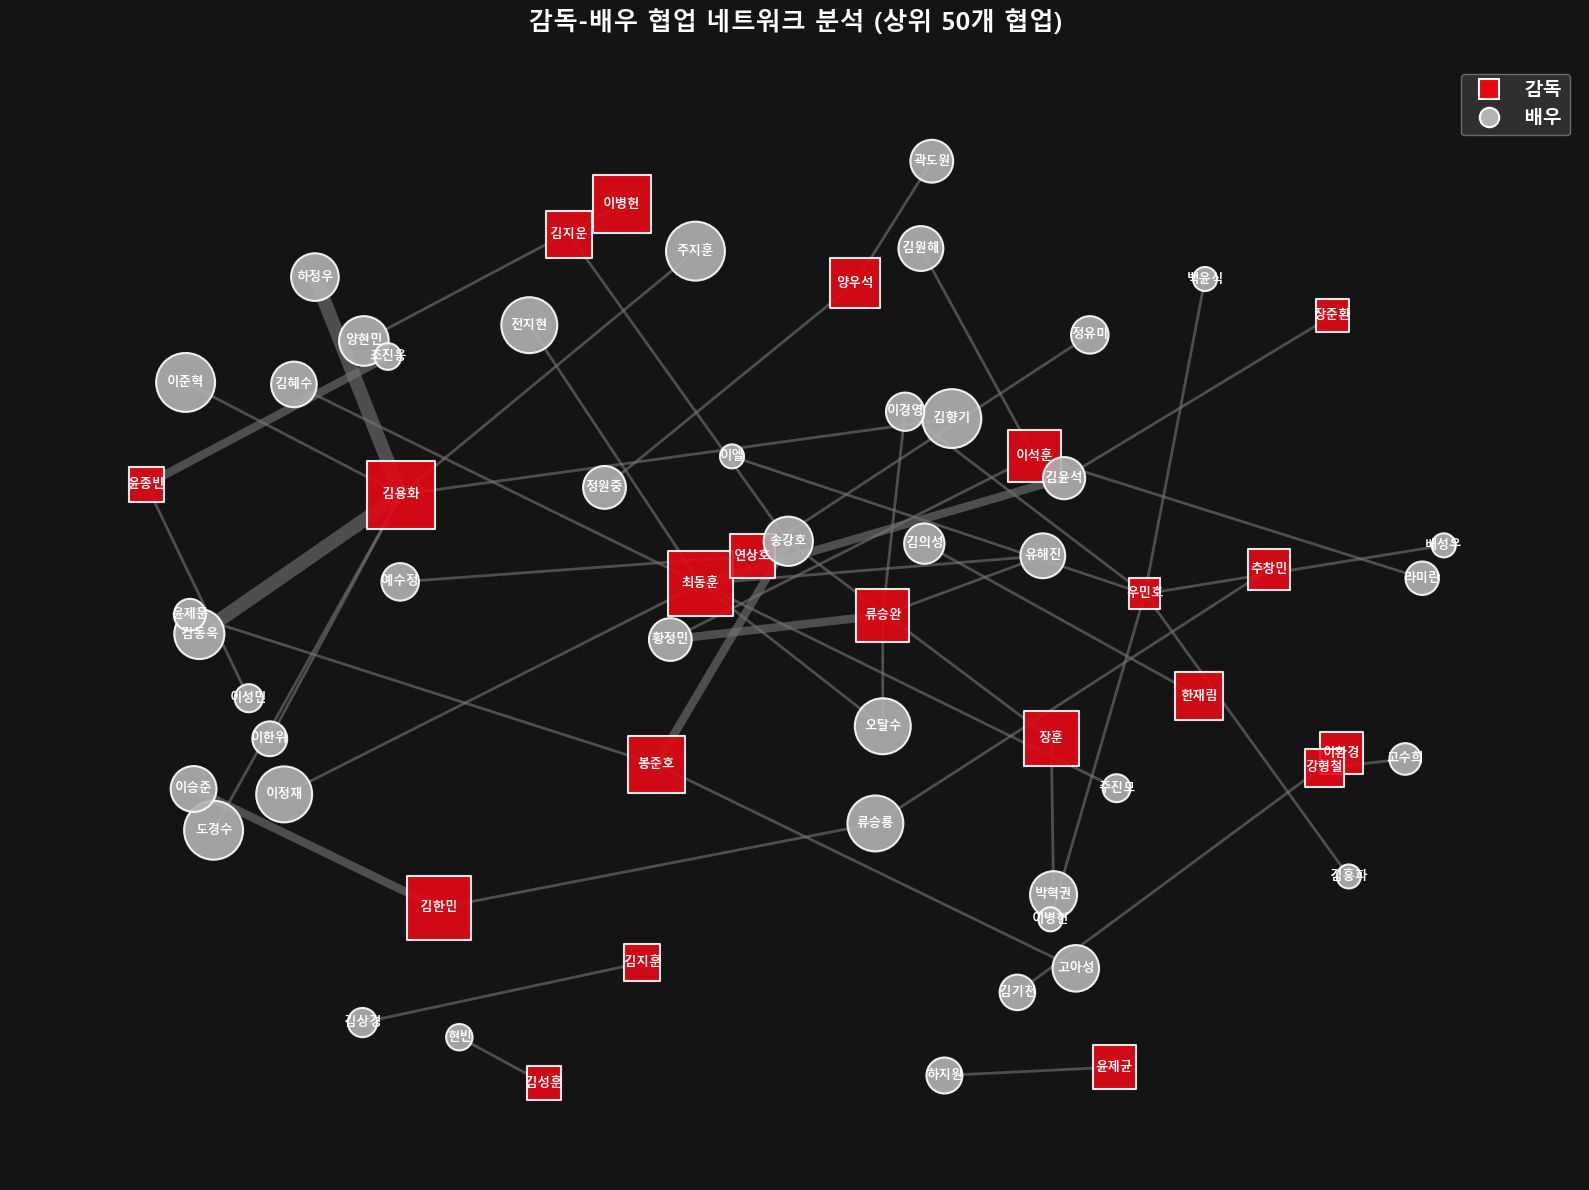

In [14]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice
from IPython.display import display
import warnings

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore', category=UserWarning)

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 파일 경로
file_path = './data/processed/kobis_weekly_final.csv'

# 데이터 로드
df = pd.read_csv(file_path)

print(f"전체 데이터 수: {len(df):,}개")

# 숫자형 컬럼 변환
numeric_columns = ['release_year', 'budget', 'revenue', 'vote_average', 'runtime']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 기간 필터링 (2005-2025)
if 'release_year' in df.columns:
    df = df[df['release_year'].between(2005, 2025)]

print(f"필터링 후 데이터 수: {len(df):,}개")

# ROI 및 순이익 계산
df['roi'] = np.where((df['budget'] > 0) & (df['revenue'] > 0),
                     df['revenue'] / df['budget'], np.nan)
df['net_profit'] = df['revenue'] - df['budget']

# 파이프 구분자 파싱 함수
def split_pipe(s):
    return [x.strip() for x in str(s).split('|') if x.strip()]

# 분석 파라미터 설정
TOP_N_CAST = 10  # 상위 배우 N명
MIN_COLLABS = 2  # 최소 협업 횟수
METRIC_EDGE_ORDER = 'avg_revenue'  # 정렬 기준
TOP_K_EDGES = 50  # 상위 K개 엣지

print(f"\n📊 네트워크 분석 설정:")
print(f"상위 배우 수: {TOP_N_CAST}명")
print(f"최소 협업 횟수: {MIN_COLLABS}회")
print(f"정렬 기준: {METRIC_EDGE_ORDER}")
print(f"상위 엣지 수: {TOP_K_EDGES}개")

# 감독-배우 협업 데이터 생성
collaboration_data = []

for _, row in df.iterrows():
    director = str(row.get('director_name_ko', '')).strip()
    if not director:
        continue
    
    cast_list = split_pipe(row.get('cast_names_ko', ''))
    
    for actor in cast_list[:TOP_N_CAST]:
        collaboration_data.append({
            'director_label': director,
            'actor_label': actor,
            'movie_id': row.get('movie_id'),
            'release_year': row.get('release_year'),
            'revenue': row.get('revenue'),
            'budget': row.get('budget'),
            'roi': row.get('roi'),
            'net_profit': row.get('net_profit')
        })

print(f"\n🤝 협업 데이터 생성:")
print(f"총 협업 관계: {len(collaboration_data):,}개")

# 협업 통계 집계
collaboration_df = pd.DataFrame(collaboration_data)
edges_df = (collaboration_df
            .groupby(['director_label', 'actor_label'], as_index=False)
            .agg(
                n_collabs=('movie_id', 'nunique'),
                avg_revenue=('revenue', 'mean'),
                avg_roi=('roi', 'mean'),
                avg_net_profit=('net_profit', 'mean'),
                first_year=('release_year', 'min'),
                last_year=('release_year', 'max')
            )
            .query('n_collabs >= @MIN_COLLABS')
            .sort_values([METRIC_EDGE_ORDER, 'n_collabs'], ascending=[False, False])
           )

print(f"유효한 협업 관계: {len(edges_df)}개")

# 상위 협업 관계 선택
top_edges = edges_df.head(TOP_K_EDGES).copy()

print(f"\n📈 상위 {TOP_K_EDGES}개 협업 관계:")
display_edges = top_edges[['director_label', 'actor_label', 'n_collabs', 'avg_revenue']].copy()
display_edges['avg_revenue'] = display_edges['avg_revenue'].apply(lambda x: f"{x/1e8:.1f}억원")
display_edges.columns = ['감독', '배우', '협업횟수', '평균수익']
display_edges.index = range(1, len(display_edges) + 1)
display(display_edges.head(10))

# 네트워크 그래프 생성
G = nx.Graph()

for _, row in top_edges.iterrows():
    director_node = ('director', row['director_label'])
    actor_node = ('actor', row['actor_label'])
    
    G.add_node(director_node, role='director', label=row['director_label'])
    G.add_node(actor_node, role='actor', label=row['actor_label'])
    
    G.add_edge(director_node, actor_node,
               weight=int(row['n_collabs']),
               avg_revenue=float(row['avg_revenue']) if pd.notna(row['avg_revenue']) else 0.0,
               avg_net_profit=float(row['avg_net_profit']) if pd.notna(row['avg_net_profit']) else 0.0,
               avg_roi=float(row['avg_roi']) if pd.notna(row['avg_roi']) else 0.0)

print(f"\n🕸️ 네트워크 그래프:")
print(f"노드 수: {G.number_of_nodes()}개")
print(f"엣지 수: {G.number_of_edges()}개")

# 레이아웃 설정
pos = nx.spring_layout(G, seed=42, k=0.8)

# 노드 분류
directors = [n for n, d in G.nodes(data=True) if d['role'] == 'director']
actors = [n for n, d in G.nodes(data=True) if d['role'] == 'actor']

# 엣지 두께 계산
weights = [G.edges[e]['weight'] for e in G.edges()]
w_min, w_max = min(weights), max(weights)
edge_widths = [2 + 8*((w-w_min)/(w_max-w_min)) for w in weights] if w_max != w_min else [6]*len(weights)

# 노드 크기 계산 (평균 수익 기준)
METRIC_NODE_SIZE = 'avg_revenue'

for _, row in top_edges.iterrows():
    for node_key, label in [(('director', row['director_label']), row['director_label']),
                           (('actor', row['actor_label']), row['actor_label'])]:
        prev_value = G.nodes[node_key].get(METRIC_NODE_SIZE, 0.0)
        current_value = float(row[METRIC_NODE_SIZE]) if pd.notna(row[METRIC_NODE_SIZE]) else 0.0
        if current_value > prev_value:
            G.nodes[node_key][METRIC_NODE_SIZE] = current_value

# 노드 크기 정규화
metric_values = {n: G.nodes[n].get(METRIC_NODE_SIZE, 0.0) for n in G.nodes()}
values_array = np.array(list(metric_values.values()), dtype=float)
values_log = np.log1p(np.abs(values_array))
vmin, vmax = float(values_log.min()), float(values_log.max())

normalized_values = {}
for node in G.nodes():
    if vmax > vmin:
        normalized_values[node] = (np.log1p(abs(metric_values[node])) - vmin) / (vmax - vmin)
    else:
        normalized_values[node] = 0.5

# 노드 크기 설정
MIN_SIZE_ACTOR, MAX_SIZE_ACTOR = 300, 1800
MIN_SIZE_DIRECTOR, MAX_SIZE_DIRECTOR = 500, 2400

node_sizes = {}
for node, norm_val in normalized_values.items():
    if G.nodes[node]['role'] == 'director':
        node_sizes[node] = MIN_SIZE_DIRECTOR + norm_val * (MAX_SIZE_DIRECTOR - MIN_SIZE_DIRECTOR)
    else:
        node_sizes[node] = MIN_SIZE_ACTOR + norm_val * (MAX_SIZE_ACTOR - MIN_SIZE_ACTOR)

# 넷플릭스 색상 팔레트
netflix_red = '#E50914'
netflix_dark = '#141414'
netflix_gray = '#757575'
netflix_light_gray = '#B3B3B3'
netflix_dark_gray = '#333333'
netflix_white = '#FFFFFF'

# 네트워크 시각화
plt.figure(figsize=(16, 12), facecolor=netflix_dark)
plt.style.use('dark_background')

# 엣지 그리기 (넷플릭스 다크 그레이)
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6, 
                      edge_color=netflix_gray)

# 감독 노드 (넷플릭스 레드 사각형)
nx.draw_networkx_nodes(
    G, pos, nodelist=directors,
    node_size=[node_sizes[n] for n in directors],
    node_color=netflix_red, node_shape='s', alpha=0.9,
    edgecolors=netflix_white, linewidths=1.5
)

# 배우 노드 (넷플릭스 라이트 그레이 원형)
nx.draw_networkx_nodes(
    G, pos, nodelist=actors,
    node_size=[node_sizes[n] for n in actors],
    node_color=netflix_light_gray, node_shape='o', alpha=0.9,
    edgecolors=netflix_white, linewidths=1.5
)

# 라벨 (넷플릭스 화이트)
labels = {n: d.get('label', '') for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, 
                       font_family='Malgun Gothic', font_color=netflix_white,
                       font_weight='bold')

# 제목 설정 (넷플릭스 스타일)
plt.title(f'감독-배우 협업 네트워크 분석 (상위 {TOP_K_EDGES}개 협업)', 
          fontsize=18, color=netflix_white, fontweight='bold', pad=25)

# 범례 (넷플릭스 색상)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label='감독',
           markerfacecolor=netflix_red, markeredgecolor=netflix_white,
           markersize=14, linestyle='None', markeredgewidth=1.5),
    Line2D([0], [0], marker='o', color='w', label='배우',
           markerfacecolor=netflix_light_gray, markeredgecolor=netflix_white,
           markersize=14, linestyle='None', markeredgewidth=1.5)
]
legend = plt.legend(handles=legend_elements, loc='upper right', 
                   frameon=True, fontsize=14, 
                   facecolor=netflix_dark_gray, edgecolor=netflix_gray)
legend.get_frame().set_alpha(0.9)
for text in legend.get_texts():
    text.set_color(netflix_white)
    text.set_fontweight('bold')

plt.axis('off')
plt.tight_layout()

# 배경색 설정
plt.gcf().patch.set_facecolor(netflix_dark)

print(f"\n🎨 네트워크 시각화 완료!")
plt.show()

In [ ]:
<!DOCTYPE html>
<html lang="ko">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Netflix Style Network Graph</title>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/d3/7.8.5/d3.min.js"></script>
    <style>
        body {
            margin: 0;
            padding: 20px;
            background: linear-gradient(135deg, #0f0f0f 0%, #1a1a1a 100%);
            font-family: 'Arial', sans-serif;
            color: #ffffff;
        }
        
        .container {
            max-width: 1200px;
            margin: 0 auto;
            background: rgba(20, 20, 20, 0.9);
            border-radius: 15px;
            padding: 30px;
            box-shadow: 0 20px 40px rgba(0, 0, 0, 0.5);
        }
        
        .title {
            text-align: center;
            font-size: 24px;
            font-weight: bold;
            margin-bottom: 30px;
            color: #ffffff;
            text-shadow: 0 2px 4px rgba(0, 0, 0, 0.8);
        }
        
        .legend {
            display: flex;
            justify-content: center;
            gap: 30px;
            margin-bottom: 20px;
        }
        
        .legend-item {
            display: flex;
            align-items: center;
            gap: 8px;
            font-size: 14px;
            color: #cccccc;
        }
        
        .legend-color {
            width: 16px;
            height: 16px;
            border-radius: 3px;
        }
        
        #network {
            width: 100%;
            height: 600px;
            background: radial-gradient(circle at center, #1a1a1a 0%, #0a0a0a 100%);
            border-radius: 10px;
            border: 1px solid #333;
        }
        
        .node-circle {
            stroke-width: 2;
            cursor: pointer;
            filter: drop-shadow(0 2px 4px rgba(0, 0, 0, 0.8));
        }
        
        .node-text {
            fill: white;
            font-size: 11px;
            font-weight: 500;
            text-anchor: middle;
            pointer-events: none;
            text-shadow: 0 1px 2px rgba(0, 0, 0, 0.9);
        }
        
        .link {
            stroke: #444444;
            stroke-width: 1.5;
            opacity: 0.6;
        }
        
        .node-circle:hover {
            stroke-width: 3;
            filter: drop-shadow(0 4px 8px rgba(229, 9, 20, 0.6));
        }
        
        .link:hover {
            stroke: #e50914;
            opacity: 1;
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="title">Top-40 감독·배우 콜보 네트워크 (장편기준: avg_revenue, 노드크기: avg_revenue)</div>
        
        <div class="legend">
            <div class="legend-item">
                <div class="legend-color" style="background: #e50914;"></div>
                <span>감독</span>
            </div>
            <div class="legend-item">
                <div class="legend-color" style="background: #757575;"></div>
                <span>배우</span>
            </div>
        </div>
        
        <svg id="network"></svg>
    </div>

    <script>
        // 데이터 정의 (원본 그래프에서 추출한 노드들)
        const nodes = [
            // 감독들 (빨간색 원형)
            {id: "가브리엘레", type: "director", revenue: 150},
            {id: "김보라", type: "director", revenue: 120},
            {id: "김영훈", type: "director", revenue: 180},
            {id: "김윤석", type: "director", revenue: 140},
            {id: "김지훈", type: "director", revenue: 160},
            {id: "나홍진", type: "director", revenue: 200},
            {id: "류승완", type: "director", revenue: 190},
            {id: "박훈정", type: "director", revenue: 170},
            {id: "봉준호", type: "director", revenue: 250},
            {id: "손예진", type: "director", revenue: 130},
            {id: "양우석", type: "director", revenue: 160},
            {id: "유하", type: "director", revenue: 110},
            {id: "윤종빈", type: "director", revenue: 140},
            {id: "이상근", type: "director", revenue: 130},
            {id: "이준익", type: "director", revenue: 180},
            {id: "장항준", type: "director", revenue: 170},
            {id: "정지우", type: "director", revenue: 150},
            {id: "조의석", type: "director", revenue: 140},
            {id: "최동훈", type: "director", revenue: 210},
            {id: "한준희", type: "director", revenue: 120},
            
            // 배우들 (회색 사각형)
            {id: "강동원", type: "actor", revenue: 180},
            {id: "공유", type: "actor", revenue: 200},
            {id: "김래원", type: "actor", revenue: 160},
            {id: "김민희", type: "actor", revenue: 140},
            {id: "김윤진", type: "actor", revenue: 150},
            {id: "김혜수", type: "actor", revenue: 170},
            {id: "마동석", type: "actor", revenue: 190},
            {id: "박서준", type: "actor", revenue: 180},
            {id: "박소담", type: "actor", revenue: 160},
            {id: "송강호", type: "actor", revenue: 220},
            {id: "신민아", type: "actor", revenue: 150},
            {id: "유아인", type: "actor", revenue: 170},
            {id: "유지태", type: "actor", revenue: 160},
            {id: "윤계상", type: "actor", revenue: 140},
            {id: "이성민", type: "actor", revenue: 180},
            {id: "이병헌", type: "actor", revenue: 190},
            {id: "이정재", type: "actor", revenue: 200},
            {id: "전도연", type: "actor", revenue: 170},
            {id: "조진웅", type: "actor", revenue: 160},
            {id: "최민식", type: "actor", revenue: 210}
        ];

        // 링크 정의 (원본 그래프의 연결 관계를 기반으로)
        const links = [
            {source: "봉준호", target: "송강호"},
            {source: "봉준호", target: "최민식"},
            {source: "봉준호", target: "박소담"},
            {source: "최동훈", target: "이정재"},
            {source: "최동훈", target: "전도연"},
            {source: "최동훈", target: "유지태"},
            {source: "나홍진", target: "이성민"},
            {source: "나홍진", target: "윤계상"},
            {source: "류승완", target: "조진웅"},
            {source: "류승완", target: "마동석"},
            {source: "박훈정", target: "강동원"},
            {source: "박훈정", target: "이병헌"},
            {source: "이준익", target: "박서준"},
            {source: "이준익", target: "김혜수"},
            {source: "장항준", target: "공유"},
            {source: "장항준", target: "신민아"},
            {source: "양우석", target: "유아인"},
            {source: "김지훈", target: "김래원"},
            {source: "김영훈", target: "김민희"},
            {source: "정지우", target: "김윤진"},
            // 추가 연결들...
            {source: "송강호", target: "이성민"},
            {source: "최민식", target: "조진웅"},
            {source: "강동원", target: "공유"},
            {source: "마동석", target: "박서준"},
            {source: "이병헌", target: "이정재"},
            {source: "김혜수", target: "전도연"}
        ];

        // SVG 설정
        const svg = d3.select("#network");
        const width = 1140;
        const height = 600;
        
        svg.attr("width", width).attr("height", height);

        // 시뮬레이션 설정
        const simulation = d3.forceSimulation(nodes)
            .force("link", d3.forceLink(links).id(d => d.id).distance(80).strength(0.5))
            .force("charge", d3.forceManyBody().strength(-300))
            .force("center", d3.forceCenter(width / 2, height / 2))
            .force("collision", d3.forceCollide().radius(d => Math.sqrt(d.revenue) * 0.8 + 5));

        // 링크 그리기
        const link = svg.append("g")
            .selectAll("line")
            .data(links)
            .join("line")
            .attr("class", "link");

        // 노드 그룹 생성
        const node = svg.append("g")
            .selectAll("g")
            .data(nodes)
            .join("g")
            .call(d3.drag()
                .on("start", dragstarted)
                .on("drag", dragged)
                .on("end", dragended));

        // 노드 모양 그리기
        node.each(function(d) {
            const nodeGroup = d3.select(this);
            const radius = Math.sqrt(d.revenue) * 0.8 + 8;
            
            if (d.type === "director") {
                // 감독은 원형 (빨간색)
                nodeGroup.append("circle")
                    .attr("class", "node-circle")
                    .attr("r", radius)
                    .attr("fill", "#e50914")
                    .attr("stroke", "#ffffff");
            } else {
                // 배우는 사각형 (회색)
                nodeGroup.append("rect")
                    .attr("class", "node-circle")
                    .attr("width", radius * 1.6)
                    .attr("height", radius * 1.6)
                    .attr("x", -radius * 0.8)
                    .attr("y", -radius * 0.8)
                    .attr("rx", 3)
                    .attr("fill", "#757575")
                    .attr("stroke", "#ffffff");
            }
            
            // 텍스트 추가
            nodeGroup.append("text")
                .attr("class", "node-text")
                .attr("dy", "0.3em")
                .text(d.id);
        });

        // 애니메이션 업데이트
        simulation.on("tick", () => {
            link
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node.attr("transform", d => `translate(${d.x},${d.y})`);
        });

        // 드래그 함수들
        function dragstarted(event, d) {
            if (!event.active) simulation.alphaTarget(0.3).restart();
            d.fx = d.x;
            d.fy = d.y;
        }

        function dragged(event, d) {
            d.fx = event.x;
            d.fy = event.y;
        }

        function dragended(event, d) {
            if (!event.active) simulation.alphaTarget(0);
            d.fx = null;
            d.fy = null;
        }

        // 호버 효과
        node.on("mouseover", function(event, d) {
            d3.select(this).select(".node-circle")
                .transition().duration(200)
                .attr("stroke-width", 4)
                .attr("filter", "drop-shadow(0 4px 12px rgba(229, 9, 20, 0.8))");
            
            // 연결된 링크 하이라이트
            link.transition().duration(200)
                .attr("stroke", l => 
                    (l.source.id === d.id || l.target.id === d.id) ? "#e50914" : "#444444")
                .attr("opacity", l => 
                    (l.source.id === d.id || l.target.id === d.id) ? 1 : 0.3);
        })
        .on("mouseout", function(event, d) {
            d3.select(this).select(".node-circle")
                .transition().duration(200)
                .attr("stroke-width", 2)
                .attr("filter", "drop-shadow(0 2px 4px rgba(0, 0, 0, 0.8))");
            
            // 링크 원상복구
            link.transition().duration(200)
                .attr("stroke", "#444444")
                .attr("opacity", 0.6);
        });

        // 초기 애니메이션
        simulation.alpha(1).restart();
    </script>
</body>
</html>